In [1]:
import numpy as np
from matplotlib import pyplot as plt

from pyloki.config import ParamLimits, PulsarSearchConfig
from pyloki.detection import thresholding
from pyloki.ffa import DynamicProgramming
from pyloki.pattern import generate_branching_pattern
from pyloki.periodogram import PruningStatsPlotter, ScatteredPeriodogram
from pyloki.prune import prune_dyp_tree
from pyloki.simulation.pulse import PulseSignalConfig

tobs = 2147.483648


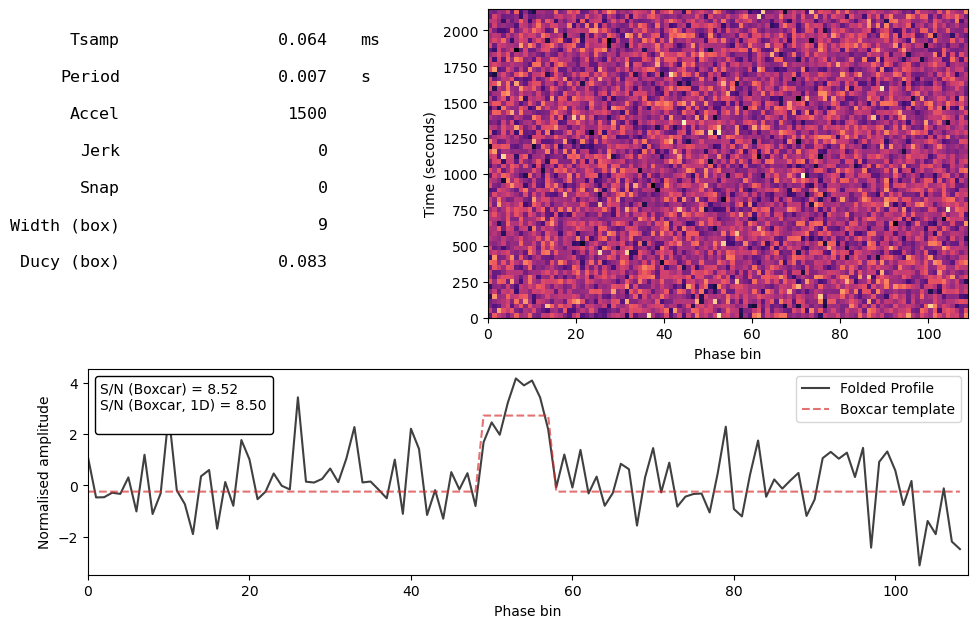

In [2]:
pulsar_period = 0.007
dt = 64e-6
accel = 1500
nsamps = 2**25
mod_kwargs = {"acc": accel}
cfg = PulseSignalConfig(period=pulsar_period, dt=dt, nsamps=nsamps, snr=8.5, ducy=0.1, mod_kwargs=mod_kwargs)
print(f"tobs = {cfg.tobs}")
tim_data = cfg.generate(shape="gaussian")
tim_data.plot_fold(cfg.freq, cfg.fold_bins, mod_kwargs=mod_kwargs)
plt.show()

In [3]:
tol_bins = 1 #cfg.tol_bins
fold_bins = 64 #cfg.fold_bins
p = ParamLimits.from_taylor((140.0, 145.0), (-2500.0, 2500.0) )
print(f"Param limits: {p.limits}")
bseg_brute = cfg.nsamps // 8192
bseg_ffa = cfg.nsamps // 128
search_cfg = PulsarSearchConfig(nsamps=cfg.nsamps, tsamp=cfg.dt, nbins=fold_bins, tol_bins=tol_bins, param_limits=p.limits,
                                bseg_brute=bseg_brute, bseg_ffa=bseg_ffa, prune_poly_order=2, ducy_max=0.2, wtsp=1.5, use_fft_shifts=True)
dyp = DynamicProgramming(tim_data, search_cfg)
dyp.initialize()
dyp.execute()

Param limits: [(-2500.0, 2500.0), (140.0, 145.0)]


2025-09-20 13:58:09 INFO     - pyloki.ffa - FFA initialize: Grid sizes: [7.52164558e+06 1.19209290e-01]

2025-09-20 13:58:11 INFO     - pyloki.ffa - ffa level:  0, leaves: 5.36, fold dims: (8192, 1, 41, 2, 33)

                    INFO     - pyloki.ffa - ffa_initialize finished, Elapsed time: 1.485 seconds

Output()

2025-09-20 13:58:14 INFO     - pyloki.ffa - ffa level:  1, leaves:  6.38, fold dims: (4096, 1, 83, 2, 33)

                    INFO     - pyloki.ffa - ffa level:  2, leaves:  7.38, fold dims: (2048, 1, 167, 2, 33)

                    INFO     - pyloki.ffa - ffa level:  3, leaves:  8.39, fold dims: (1024, 1, 335, 2, 33)

                    INFO     - pyloki.ffa - ffa level:  4, leaves:  9.39, fold dims: (512, 1, 671, 2, 33)

                    INFO     - pyloki.ffa - ffa level:  5, leaves: 10.39, fold dims: (256, 1, 1342, 2, 33)

2025-09-20 13:58:15 INFO     - pyloki.ffa - ffa level:  6, leaves: 12.39, fold dims: (128, 2, 2684, 2, 33)

                    INFO     - pyloki.ffa - FFA complete: Grid sizes: [1.83633925e+03 1.86264515e-03]

                    INFO     - pyloki.ffa - ffa_execute finished, Elapsed time: 3.624 seconds

In [4]:
branching_pattern = generate_branching_pattern(dyp.param_arr, dyp.dparams_limited, dyp.cfg.param_limits, dyp.cfg.tseg_ffa, dyp.nsegments,
                                               dyp.cfg.nbins, dyp.cfg.tol_bins)
branching_pattern

array([8.       , 3.       , 2.       , 3.       , 1.       , 1.       ,
       2.       , 3.       , 1.       , 1.       , 1.       , 1.       ,
       1.       , 3.       , 2.       , 1.       , 1.       , 1.       ,
       1.       , 1.       , 1.       , 1.       , 1.       , 1.       ,
       3.       , 1.       , 1.       , 1.       , 1.       , 1.       ,
       2.       , 1.       , 1.       , 1.       , 1.       , 1.       ,
       1.       , 1.       , 1.       , 1.       , 1.       , 1.       ,
       1.       , 3.       , 1.       , 1.       , 1.       , 1.       ,
       1.       , 1.       , 1.       , 1.       , 1.       , 1.       ,
       1.       , 1.       , 1.       , 1.       , 1.       , 1.       ,
       1.       , 1.       , 2.       , 1.       , 1.       , 1.       ,
       1.       , 1.       , 1.       , 1.       , 1.       , 1.       ,
       1.       , 1.       , 1.       , 1.9485842, 2.0514158, 1.       ,
       1.       , 1.       , 1.       , 1.       , 

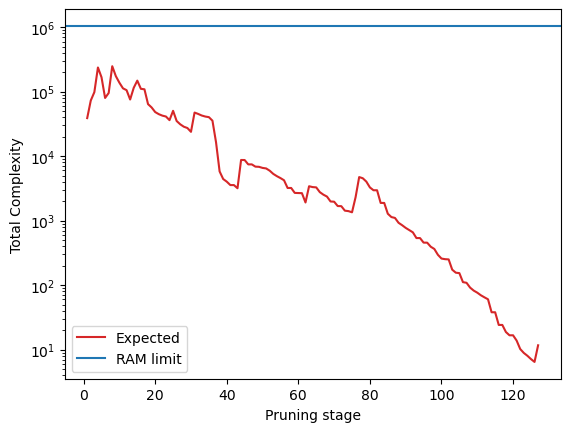

In [5]:
thresholds = np.array([2.1, 2.5, 2.6, 2.5, 2.7, 3. , 3.1, 2.9, 3.1, 3.1, 3.1, 2.9, 3.2,
       3.5, 3.6, 3.6, 3.2, 3.7, 3.6, 3.6, 3.5, 3.4, 3.3, 3.4, 3.9, 4. ,
       3.9, 3.8, 3.7, 3.8, 3.5, 3.6, 3.6, 3.5, 3.4, 3.6, 4.1, 4.5, 4.5,
       4.4, 4.4, 4. , 4.3, 4.3, 4. , 4.3, 4. , 4.2, 4. , 4.1, 4. , 4.1,
       4.2, 4.2, 4.2, 4.2, 4.4, 4. , 4.4, 4.2, 4.1, 4.5, 4.5, 4.4, 4.3,
       4.5, 4.5, 4.5, 4.6, 4.4, 4.6, 4.4, 4.6, 4.5, 4.5, 4.6, 4.4, 4.5,
       4.6, 4.7, 4.7, 4.4, 4.9, 4.5, 5. , 5. , 4.9, 5. , 5. , 5. , 5. ,
       5. , 5.1, 4.9, 5.1, 4.9, 5.1, 5.1, 5.2, 5.2, 5.1, 5. , 5.3, 5.3,
       5.2, 5.4, 5.3, 5.4, 5.4, 5.4, 5.4, 5.4, 5.4, 5.6, 5.3, 5.7, 5.3,
       5.7, 5.7, 5.3, 5.7, 5.8, 5.8, 5.8, 5.8, 5.8, 5.8])
thresh_state = thresholding.evaluate_scheme(thresholds, branching_pattern, ref_ducy=0.1, nbins=64,
                                            ntrials=1024, snr_final=8.5, ducy_max=0.2, wtsp=1.5)
x = np.arange(1, len(branching_pattern) + 1)
plt.semilogy(x, np.array(thresh_state.get_info("complexity")) * dyp.nparam_vol, label="Expected", c="tab:red")
plt.axhline(2**20, label="RAM limit", c="tab:blue")
plt.xlabel("Pruning stage")
plt.ylabel("Total Complexity")
plt.legend()
plt.show()

In [6]:
result_file = prune_dyp_tree(dyp, thresholds, n_runs=32, max_sugg=2**20, outdir="accel_test/", file_prefix="test_accel",
                             kind="taylor", n_workers=4)

2025-09-20 13:59:28 INFO     - pyloki.prune - Starting Pruning for 32 runs, with 4 workers

Output()

2025-09-20 13:59:34 INFO     - worker_000 - Initializing pruning run with ref segment: 0

2025-09-20 13:59:35 INFO     - worker_000 - prune_initialize finished, Elapsed time: 1.302 seconds

2025-09-20 13:59:36 INFO     - worker_004 - Initializing pruning run with ref segment: 4

                    INFO     - worker_004 - prune_initialize finished, Elapsed time: 0.040 seconds

2025-09-20 13:59:38 INFO     - worker_008 - Initializing pruning run with ref segment: 8

                    INFO     - worker_008 - prune_initialize finished, Elapsed time: 0.036 seconds

2025-09-20 13:59:41 INFO     - worker_012 - Initializing pruning run with ref segment: 12

                    INFO     - worker_012 - prune_initialize finished, Elapsed time: 0.037 seconds

2025-09-20 13:59:50 INFO     - worker_000 - Pruning run complete for ref segment: 0

                    INFO     - worker_000 - Pruning stats: Score: 6.49, Leaves: 3.81

                    INFO     - worker_000 - Pruning time: Total: 4.6s (score: 45% | shift_add: 16% | resolve: 12% |
                             batch_add: 11%)

2025-09-20 13:59:51 INFO     - worker_004 - Pruning run complete for ref segment: 4

                    INFO     - worker_004 - Pruning stats: Score: 6.82, Leaves: 5.17

                    INFO     - worker_004 - Pruning time: Total: 4.7s (score: 44% | shift_add: 17% | resolve: 12% |
                             batch_add: 12%)

                    INFO     - worker_016 - prune_initialize finished, Elapsed time: 0.010 seconds

                    INFO     - worker_008 - Pruning run complete for ref segment: 8

                    INFO     - worker_008 - Pruning stats: Score: 7.55, Leaves: 5.32

                    INFO     - worker_008 - Pruning time: Total: 4.6s (score: 45% | shift_add: 17% | resolve: 12% |
                             batch_add: 11%)

2025-09-20 13:59:55 INFO     - worker_020 - Initializing pruning run with ref segment: 20

                    INFO     - worker_020 - prune_initialize finished, Elapsed time: 0.009 seconds

                    INFO     - worker_012 - Pruning run complete for ref segment: 12

                    INFO     - worker_012 - Pruning stats: Score: 7.21, Leaves: 5.25

                    INFO     - worker_012 - Pruning time: Total: 5.0s (score: 44% | shift_add: 17% | batch_add: 12%
                             | resolve: 12%)

                    INFO     - worker_025 - prune_initialize finished, Elapsed time: 0.010 seconds

2025-09-20 13:59:58 INFO     - worker_016 - Pruning run complete for ref segment: 16

                    INFO     - worker_016 - Pruning stats: Score: 7.26, Leaves: 5.46

                    INFO     - worker_016 - Pruning time: Total: 5.1s (score: 45% | shift_add: 16% | batch_add: 12%
                             | resolve: 11%)

                    INFO     - worker_029 - prune_initialize finished, Elapsed time: 0.010 seconds

2025-09-20 14:00:00 INFO     - worker_020 - Pruning run complete for ref segment: 20

                    INFO     - worker_020 - Pruning stats: Score: 7.23, Leaves: 5.52

                    INFO     - worker_020 - Pruning time: Total: 4.8s (score: 45% | shift_add: 16% | batch_add: 12%
                             | resolve: 11%)

2025-09-20 14:00:02 INFO     - worker_025 - Pruning run complete for ref segment: 25

                    INFO     - worker_025 - Pruning stats: Score: 6.08, Leaves: 2.58

                    INFO     - worker_025 - Pruning time: Total: 4.5s (score: 45% | shift_add: 16% | resolve: 11% |
                             batch_add: 11%)

2025-09-20 14:00:04 INFO     - worker_029 - Pruning run complete for ref segment: 29

                    INFO     - worker_029 - Pruning stats: Score: 6.48, Leaves: 4.17

                    INFO     - worker_029 - Pruning time: Total: 5.0s (score: 44% | shift_add: 17% | batch_add: 12%
                             | resolve: 11%)

2025-09-20 14:00:08 INFO     - worker_033 - Initializing pruning run with ref segment: 33

                    INFO     - worker_033 - prune_initialize finished, Elapsed time: 0.010 seconds

                    INFO     - worker_037 - prune_initialize finished, Elapsed time: 0.009 seconds

2025-09-20 14:00:13 INFO     - worker_033 - Pruning run complete at level: 127

                    INFO     - worker_033 - Pruning run complete for ref segment: 33

                    INFO     - worker_033 - Pruning stats: Score: 5.78, Leaves: 1.00

                    INFO     - worker_033 - Pruning time: Total: 4.9s (score: 45% | shift_add: 16% | batch_add: 12%
                             | resolve: 11%)

2025-09-20 14:00:15 INFO     - worker_041 - Initializing pruning run with ref segment: 41

                    INFO     - worker_041 - prune_initialize finished, Elapsed time: 0.010 seconds

2025-09-20 14:00:16 INFO     - worker_037 - Pruning run complete for ref segment: 37

                    INFO     - worker_037 - Pruning stats: Score: 6.33, Leaves: 3.32

                    INFO     - worker_037 - Pruning time: Total: 4.8s (score: 45% | shift_add: 16% | batch_add: 12%
                             | resolve: 11%)

2025-09-20 14:00:19 INFO     - worker_045 - Initializing pruning run with ref segment: 45

                    INFO     - worker_045 - prune_initialize finished, Elapsed time: 0.010 seconds

2025-09-20 14:00:20 INFO     - worker_041 - Pruning run complete for ref segment: 41

                    INFO     - worker_041 - Pruning stats: Score: 6.42, Leaves: 2.58

                    INFO     - worker_041 - Pruning time: Total: 5.0s (score: 45% | shift_add: 16% | resolve: 12% |
                             batch_add: 11%)

                    INFO     - worker_049 - prune_initialize finished, Elapsed time: 0.009 seconds

2025-09-20 14:00:24 INFO     - worker_045 - Pruning run complete for ref segment: 45

                    INFO     - worker_045 - Pruning stats: Score: 6.61, Leaves: 3.58

                    INFO     - worker_045 - Pruning time: Total: 4.6s (score: 44% | shift_add: 16% | batch_add: 12%
                             | resolve: 12%)

2025-09-20 14:00:27 INFO     - worker_049 - Pruning run complete for ref segment: 49

                    INFO     - worker_049 - Pruning stats: Score: 6.60, Leaves: 4.32

                    INFO     - worker_049 - Pruning time: Total: 4.8s (score: 45% | shift_add: 16% | batch_add: 12%
                             | resolve: 11%)

                    INFO     - worker_053 - prune_initialize finished, Elapsed time: 0.009 seconds

2025-09-20 14:00:38 INFO     - worker_053 - Pruning run complete for ref segment: 53

                    INFO     - worker_053 - Pruning stats: Score: 6.47, Leaves: 3.58

                    INFO     - worker_053 - Pruning time: Total: 4.6s (score: 44% | shift_add: 16% | batch_add: 12%
                             | resolve: 11%)

2025-09-20 14:00:44 INFO     - worker_057 - Initializing pruning run with ref segment: 57

                    INFO     - worker_057 - prune_initialize finished, Elapsed time: 0.009 seconds

                    INFO     - worker_061 - prune_initialize finished, Elapsed time: 0.010 seconds

2025-09-20 14:00:49 INFO     - worker_057 - Pruning run complete for ref segment: 57

                    INFO     - worker_057 - Pruning stats: Score: 6.42, Leaves: 4.00

                    INFO     - worker_057 - Pruning time: Total: 5.1s (score: 45% | shift_add: 17% | resolve: 12% |
                             batch_add: 11%)

                    INFO     - worker_066 - Initializing pruning run with ref segment: 66

                    INFO     - worker_066 - prune_initialize finished, Elapsed time: 0.009 seconds

2025-09-20 14:00:52 INFO     - worker_061 - Pruning run complete for ref segment: 61

                    INFO     - worker_061 - Pruning stats: Score: 6.69, Leaves: 4.32

                    INFO     - worker_061 - Pruning time: Total: 5.1s (score: 44% | shift_add: 16% | batch_add: 12%
                             | resolve: 11%)

                    INFO     - worker_070 - prune_initialize finished, Elapsed time: 0.009 seconds

2025-09-20 14:00:55 INFO     - worker_066 - Pruning run complete for ref segment: 66

                    INFO     - worker_066 - Pruning stats: Score: 6.19, Leaves: 3.32

                    INFO     - worker_066 - Pruning time: Total: 5.4s (score: 44% | shift_add: 16% | batch_add: 12%
                             | resolve: 11%)

                    INFO     - worker_074 - prune_initialize finished, Elapsed time: 0.010 seconds

2025-09-20 14:01:00 INFO     - worker_070 - Pruning run complete for ref segment: 70

                    INFO     - worker_070 - Pruning stats: Score: 6.26, Leaves: 3.81

                    INFO     - worker_070 - Pruning time: Total: 5.2s (score: 45% | shift_add: 16% | batch_add: 12%
                             | resolve: 11%)

2025-09-20 14:01:03 INFO     - worker_074 - Pruning run complete for ref segment: 74

                    INFO     - worker_074 - Pruning stats: Score: 6.23, Leaves: 3.32

                    INFO     - worker_074 - Pruning time: Total: 4.8s (score: 44% | shift_add: 17% | batch_add: 11%
                             | resolve: 11%)

2025-09-20 14:01:09 INFO     - worker_078 - Initializing pruning run with ref segment: 78

                    INFO     - worker_078 - prune_initialize finished, Elapsed time: 0.009 seconds

2025-09-20 14:01:14 INFO     - worker_078 - Pruning run complete for ref segment: 78

                    INFO     - worker_078 - Pruning stats: Score: 6.24, Leaves: 4.32

                    INFO     - worker_078 - Pruning time: Total: 4.7s (score: 44% | shift_add: 16% | batch_add: 12%
                             | resolve: 11%)

                    INFO     - worker_082 - prune_initialize finished, Elapsed time: 0.010 seconds

2025-09-20 14:01:23 INFO     - worker_082 - Pruning run complete for ref segment: 82

                    INFO     - worker_082 - Pruning stats: Score: 6.37, Leaves: 3.81

                    INFO     - worker_082 - Pruning time: Total: 4.9s (score: 45% | shift_add: 16% | batch_add: 12%
                             | resolve: 11%)

                    INFO     - worker_086 - prune_initialize finished, Elapsed time: 0.009 seconds

2025-09-20 14:01:35 INFO     - worker_086 - Pruning run complete for ref segment: 86

                    INFO     - worker_086 - Pruning stats: Score: 7.76, Leaves: 4.70

                    INFO     - worker_086 - Pruning time: Total: 4.9s (score: 45% | shift_add: 16% | batch_add: 12%
                             | resolve: 11%)

2025-09-20 14:01:41 INFO     - worker_090 - Initializing pruning run with ref segment: 90

                    INFO     - worker_090 - prune_initialize finished, Elapsed time: 0.010 seconds

                    INFO     - worker_094 - prune_initialize finished, Elapsed time: 0.009 seconds

2025-09-20 14:01:46 INFO     - worker_090 - Pruning run complete for ref segment: 90

                    INFO     - worker_090 - Pruning stats: Score: 6.29, Leaves: 5.46

                    INFO     - worker_090 - Pruning time: Total: 4.7s (score: 44% | shift_add: 17% | resolve: 12% |
                             batch_add: 11%)

                    INFO     - worker_098 - prune_initialize finished, Elapsed time: 0.010 seconds

2025-09-20 14:01:49 INFO     - worker_094 - Pruning run complete for ref segment: 94

                    INFO     - worker_094 - Pruning stats: Score: 8.19, Leaves: 4.00

                    INFO     - worker_094 - Pruning time: Total: 4.9s (score: 44% | shift_add: 16% | batch_add: 12%
                             | resolve: 11%)

                    INFO     - worker_102 - prune_initialize finished, Elapsed time: 0.009 seconds

2025-09-20 14:01:52 INFO     - worker_098 - Pruning run complete for ref segment: 98

                    INFO     - worker_098 - Pruning stats: Score: 6.58, Leaves: 3.32

                    INFO     - worker_098 - Pruning time: Total: 4.8s (score: 45% | shift_add: 16% | batch_add: 12%
                             | resolve: 12%)

2025-09-20 14:01:54 INFO     - worker_107 - Initializing pruning run with ref segment: 107

                    INFO     - worker_107 - prune_initialize finished, Elapsed time: 0.010 seconds

2025-09-20 14:01:55 INFO     - worker_102 - Pruning run complete for ref segment: 102

                    INFO     - worker_102 - Pruning stats: Score: 6.39, Leaves: 4.00

                    INFO     - worker_102 - Pruning time: Total: 4.9s (score: 45% | shift_add: 16% | batch_add: 12%
                             | resolve: 11%)

                    INFO     - worker_111 - prune_initialize finished, Elapsed time: 0.009 seconds

2025-09-20 14:02:00 INFO     - worker_107 - Pruning run complete for ref segment: 107

                    INFO     - worker_107 - Pruning stats: Score: 6.90, Leaves: 5.39

                    INFO     - worker_107 - Pruning time: Total: 5.2s (score: 44% | shift_add: 17% | resolve: 11% |
                             batch_add: 11%)

2025-09-20 14:02:05 INFO     - worker_111 - Pruning run complete for ref segment: 111

                    INFO     - worker_111 - Pruning stats: Score: 6.86, Leaves: 5.39

                    INFO     - worker_111 - Pruning time: Total: 5.0s (score: 44% | shift_add: 16% | batch_add: 12%
                             | resolve: 11%)

2025-09-20 14:02:07 INFO     - worker_115 - Initializing pruning run with ref segment: 115

                    INFO     - worker_115 - prune_initialize finished, Elapsed time: 0.009 seconds

2025-09-20 14:02:13 INFO     - worker_115 - Pruning run complete for ref segment: 115

                    INFO     - worker_115 - Pruning stats: Score: 6.18, Leaves: 3.00

                    INFO     - worker_115 - Pruning time: Total: 5.1s (score: 45% | shift_add: 16% | batch_add: 12%
                             | resolve: 11%)

2025-09-20 14:02:19 INFO     - worker_119 - Initializing pruning run with ref segment: 119

                    INFO     - worker_119 - prune_initialize finished, Elapsed time: 0.009 seconds

2025-09-20 14:02:24 INFO     - worker_119 - Pruning run complete for ref segment: 119

                    INFO     - worker_119 - Pruning stats: Score: 6.38, Leaves: 3.81

                    INFO     - worker_119 - Pruning time: Total: 5.0s (score: 46% | shift_add: 16% | batch_add: 12%
                             | resolve: 11%)

                    INFO     - worker_123 - prune_initialize finished, Elapsed time: 0.009 seconds

2025-09-20 14:02:35 INFO     - worker_123 - Pruning run complete for ref segment: 123

                    INFO     - worker_123 - Pruning stats: Score: 6.49, Leaves: 5.00

                    INFO     - worker_123 - Pruning time: Total: 4.9s (score: 44% | shift_add: 17% | resolve: 12% |
                             batch_add: 11%)

2025-09-20 14:02:38 INFO     - worker_127 - Initializing pruning run with ref segment: 127

                    INFO     - worker_127 - prune_initialize finished, Elapsed time: 0.009 seconds

2025-09-20 14:02:43 INFO     - worker_127 - Pruning run complete for ref segment: 127

                    INFO     - worker_127 - Pruning stats: Score: 6.54, Leaves: 4.17

                    INFO     - worker_127 - Pruning time: Total: 4.6s (score: 44% | shift_add: 16% | batch_add: 12%
                             | resolve: 12%)

2025-09-20 14:02:44 INFO     - pyloki.prune - Pruning complete. Results saved to                                   
                             accel_test/test_accel_pruning_nstages_128_results.h5

In [7]:
pgram = ScatteredPeriodogram.load(result_file)
print(f"True params, a: {cfg.mod_kwargs["acc"]:.3f}, f: {cfg.freq:.10f}")
print(pgram.get_summary_cands(10, run_id=None))

True params, a: 1500.000, f: 142.8571428571
Top candidates:
dparams: daccel: 0.2097861257, dfreq: 1.455191523e-05
Run: 094_24, S/N: 8.19, accel: 1500.06, freq: 142.857135
Run: 094_24, S/N: 8.19, accel: 1500.06, freq: 142.857150
Run: 086_22, S/N: 7.76, accel: 1500.22, freq: 142.857124
Run: 086_22, S/N: 7.75, accel: 1500.22, freq: 142.857110
Run: 008_03, S/N: 7.55, accel: 1334.34, freq: 142.541953
Run: 008_03, S/N: 7.51, accel: 1334.34, freq: 142.541938
Run: 016_05, S/N: 7.26, accel: 1500.42, freq: 142.857154
Run: 016_05, S/N: 7.24, accel: 1500.00, freq: 142.857140
Run: 020_06, S/N: 7.23, accel: 1499.91, freq: 142.857144
Run: 020_06, S/N: 7.23, accel: 1499.91, freq: 142.857159


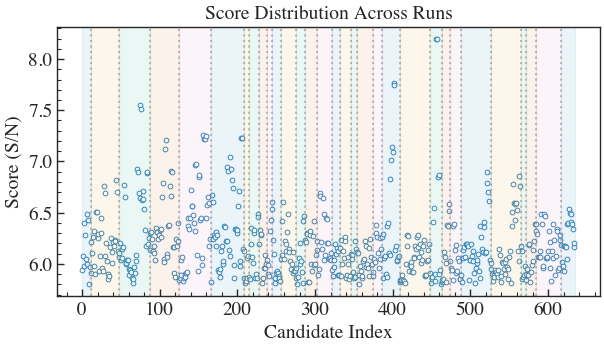

In [8]:
pgram.plot_scores(kind="scatter", run_id=None)
plt.show()

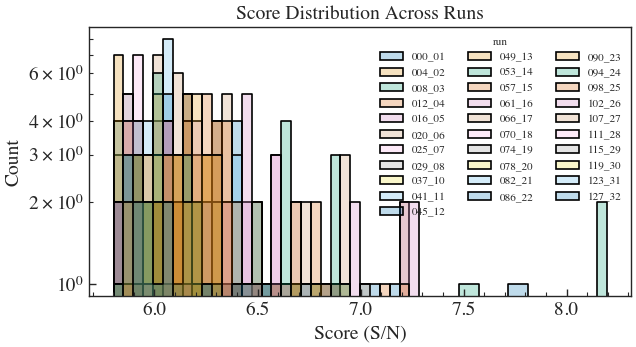

In [9]:
pgram.plot_scores(kind="hist", run_id=None)
plt.show()

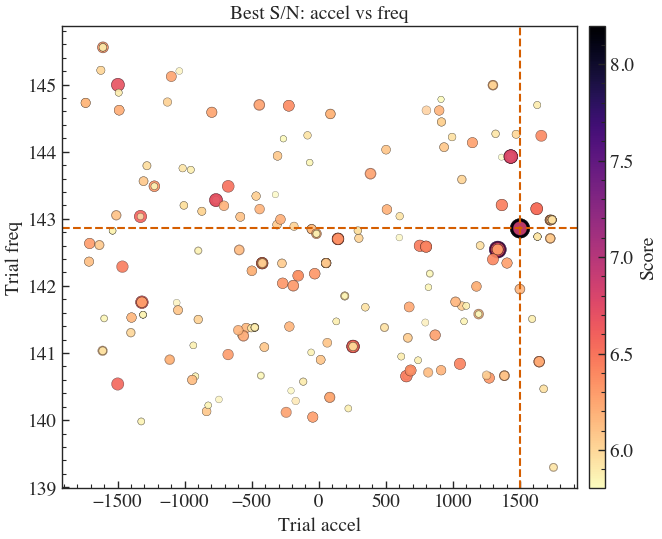

In [10]:
pgram.plot_correlation("accel", "freq", true_values={"accel": cfg.mod_kwargs["acc"], "freq": cfg.freq}, run_id=None)
plt.show()

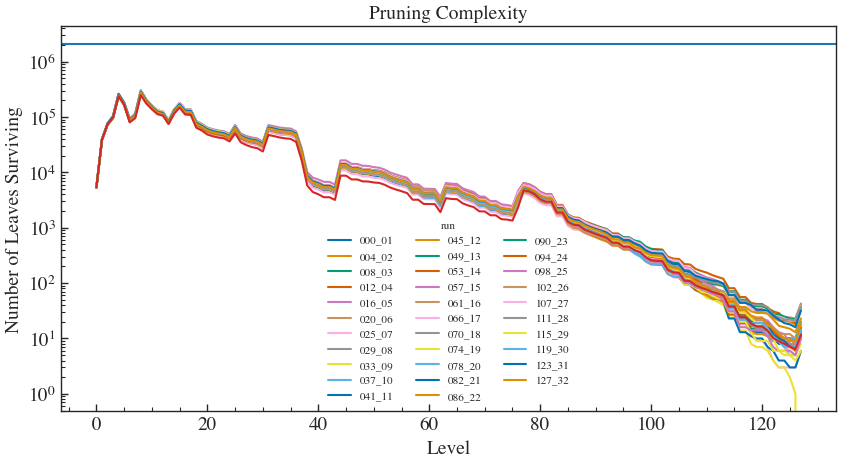

In [11]:
pstats = PruningStatsPlotter.load(result_file)
fig = pstats.plot_level_stats(run_id=None)
x = np.arange(0, len(branching_pattern) + 1)
ax_list = fig.axes
ax_list[0].plot(x, np.concatenate(([1], thresh_state.get_info("complexity"))) * dyp.nparam_vol, label="Expected", c="tab:red")
ax_list[0].axhline(2**21, label="RAM limit", c="tab:blue")
plt.show()